# Introduction to Compucter Vision. Assignment 1
### Alfiya Mussabekova

In [1]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random


## Problem 1. Adaptive thresholding 

In the cell below the implementation of adaptive thresholding algorithm from scratch is represented. First, if image is in `RGB` or `BGR` format, it is being converted to gray scale image, so that image is in 2 dimensions. Then, Gaussian filter is computed using the following formula:

$$G(x, y) = \frac{1}{2\pi\sigma^2} \cdot e^{-\frac{x^2 + y^2}{2\sigma}}$$

I use $x = y = -2 ... 2$, where the number of elements is equal to `block_size` and $\sigma = 1$. Then, image is padded with `block_size / 2` width by $0$, so that when mean/gaussian of region will be counted for edges there won't be out of index error. After this, for each pixel in the image take neighboorhood region with `block_size` (current pixel is the center pixel) and find `threshold` using mean or applying gaussian filter depending on the `thresholding_type`. If the current pixel's value greater than threshold then it is $1$ (white), otherwise it is $0$ (black).

In [21]:
def adaptive_thresholding(image, thresholding_type='mean', block_size=3):
  """
    Function calculates adaptive thresholding for a given image
    Input:
      image: grayscale or color image
      thresholding_type: type of thresholding;
                         possible values: ’mean’ and ’gaussian’
      block_size: kernel size in which the threshold value is
                  calculated for the current pixel
    Output:
      image_bw: binary thresholded image
  """
  # conevert image to gray scale if needed
  if (len(image.shape) > 2):
    try: 
      image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    except:
      image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # compute Gaussian filter 
  filter = np.zeros((block_size, block_size))
  inp = np.linspace(-2, 2, block_size)
  for i, x in enumerate(inp):
    for j, y in enumerate(inp):
      filter[i][j] = 1 / (2 * np.pi) * np.exp(-(x**2 + y**2) / 2)   # use sigma = 1
  filter = filter / filter.sum()
  
  # find image shape and create resulting image
  n, m = image.shape[0], image.shape[1]
  image_bw = np.zeros((n, m))
  
  # pad image
  image_gray = np.pad(image_gray, block_size//2)
  for i in range(0, n):
    for j in range(0, m):
      ix = i + block_size
      jx = j + block_size
      block = image_gray[i:ix, j:jx] # take region
      threshold = 0
      if thresholding_type == 'mean':
        threshold = block.mean()  # count mean of the region
      elif thresholding_type == 'gaussian':
        block = block * filter    # apply gaussian filter
        threshold = np.sum(block)
      else:
        print('Wrong thresholding type!')
      # apply thresholding
      if image_gray[i + block_size // 2][j + block_size // 2] > threshold:
        image_bw[i][j] = 1
  
  return image_bw

To see how `adaptive_thresholding` function workd I used sudoku image from the lectures. It is possible to change `block_size` and `thresholding_type` interactively. Binary image is displayed below.

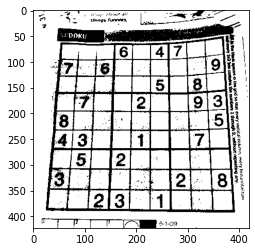

In [23]:
image = cv2.imread("sudoku.jpeg", cv2.IMREAD_COLOR)
# set parameters
#@title Parameters { run: "auto" }
block_size = 71 #@param {type:"slider", min:1, max:100, step:2}
thresholding_type = 'mean' #@param ["mean", "gaussian"]
image_res = adaptive_thresholding(image, thresholding_type=thresholding_type, block_size=block_size)
plt.imshow(image_res, cmap='gray')

## Problem 2. Count object size and rank them

To correctly identify objects, the following steps are done with image:
1. convert to gray scale image
2. blur using Gaussian blur
3. threshold using adaptive threshold, so image becomes binary and inverse it
4. blur using Gaussian blur
5. apply dilation with 3x3 kernel
6. apply erosion with 3x3 kernel
7. blur using Gaussian blur 

Then, use `findContours` to find contours of the objects. Then sort themm according to `rank_by` value. During iteration over contours, for each contour count its area, perimeter, width and heights. Draw contours on the image and write its sizes. Return image with sizes of the objects. 

References:
1. https://docs.opencv.org/3.4/df/d0d/tutorial_find_contours.html
2. https://docs.opencv.org/4.5.1/da/d22/tutorial_py_canny.html
3. https://dev-gang.ru/article/python-cv-dilate-rasshirenie-izobrazhenii-s-ispolzovaniem-opencv-sp8sujfqf9/
4. https://docs.opencv.org/4.5.0/d4/d13/tutorial_py_filtering.html
5. https://theailearner.com/2020/11/03/opencv-minimum-area-rectangle/
6. https://docs.opencv.org/4.5.1/dd/d49/tutorial_py_contour_features.html



In [107]:
def calculate_sizes_and_rank(image, units='m', rank_by='area'):
  """
  Function calculates objects sizes and rank them on image
  Input:
    image: grayscale or color image
    units: unit of measurement of object size;
           possible values: ’mm’,’cm’, ’m’ or ’pixels’
    rank_by: object ranking parameter;
             possible values: ’height’, ’width’, ’perimeter’ or ’area’
  Output:
    image_result: result image with ranking and measured objects sizes
    sizes: tuple of sizes
           (heights , widths , perimeters , areas),
           where heights , widths , perimeters , areas are lists
  """
  heights = []
  widths = []
  perimeters = []
  areas = []

  # conevert image to gray scale if needed
  if (len(image.shape) > 2):
    if image.shape[0] == 3: 
      image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
      image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  # blur gray image
  image_gray = cv2.GaussianBlur(image_gray, (5, 5), 0)
  # use adaptive threshold so it becomes binary and get inverted
  thresh = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 5)
  # blur threshold
  thresh = cv2.GaussianBlur(thresh, (5, 5), 0)
  # dilation
  kernel = np.ones((3, 3), np.uint8)
  dilation = cv2.dilate(thresh, kernel, iterations = 2)
  # erosion
  erosion = cv2.erode(dilation, kernel, iterations = 1)
  # blur image after all operations above
  img = cv2.GaussianBlur(erosion, (5, 5), 0)
  
  # find contours
  contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # sort contours depending on rank_by value
  if rank_by == 'area':
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse = True)
  if rank_by == 'perimeter':
    sorted_contours = sorted(contours, key=lambda contour: cv2.arcLength(contour, True), reverse=True)
  if rank_by == 'height':
    sorted_contours = sorted(contours, key=lambda contour: cv2.minAreaRect(contour)[1][1], reverse=True)
  if rank_by == 'width':
    sorted_contours = sorted(contours, key=lambda contour: cv2.minAreaRect(contour)[1][0], reverse=True)
  rank = 0
  for i, contour in enumerate(sorted_contours):
    if i > 6:
      break
    # find center of a contour
    M = cv2.moments(contour)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    # find area of a contour
    area = cv2.contourArea(contour)
    areas.append(area)
    # find perimeter of a contour
    perimeter = cv2.arcLength(contour, True)
    perimeters.append(perimeter)
    # find width and height of a contour
    _, (width, height), angle = cv2.minAreaRect(contour)
    heights.append(height)
    widths.append(width)

    # Draw contours and put text on image 
    text_area = f"Area: {round(area, 2)}"
    text_perimeter = f"Perimeter: {round(perimeter, 2)}"
    text_width = f"Width: {round(width, 2)}"
    text_height = f"Height: {round(height, 2)}"
    x, y, w, h = cv2.boundingRect(contour)
    # don't include table into ranking
    if x == 0 or y == 0:
      continue
    rank += 1
    color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
    cv2.drawContours(image, sorted_contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
    cv2.putText(image, 
                text = str(rank), 
                org = (cx + 45, cy - 10), 
                fontScale = 1, 
                fontFace = cv2.FONT_HERSHEY_PLAIN,
                color = (15, 0, 0),
                thickness = 1, 
                lineType = cv2.LINE_AA)
    cv2.putText(image, 
                text = text_area, 
                org = (cx + 30, cy), 
                fontScale = 0.8, 
                fontFace = cv2.FONT_HERSHEY_PLAIN,
                color = (15, 0, 0),
                thickness = 1, 
                lineType = cv2.LINE_AA)
    cv2.putText(image, 
                text = text_perimeter, 
                org = (cx + 30, cy + 15), 
                fontScale = 0.8, 
                fontFace = cv2.FONT_HERSHEY_PLAIN,
                color = (15, 0, 0),
                thickness = 1, 
                lineType = cv2.LINE_AA)
    cv2.putText(image, 
                text = text_width, 
                org = (cx + 30, cy + 30), 
                fontScale = 0.8, 
                fontFace = cv2.FONT_HERSHEY_PLAIN,
                color = (15, 0, 0),
                thickness = 1, 
                lineType = cv2.LINE_AA)
    cv2.putText(image, 
                text = text_height, 
                org = (cx + 30, cy + 45), 
                fontScale = 0.8, 
                fontFace = cv2.FONT_HERSHEY_PLAIN,
                color = (15, 0, 0),
                thickness = 1, 
                lineType = cv2.LINE_AA)
 
  sizes = (heights, widths, perimeters, areas)
  return image, sizes

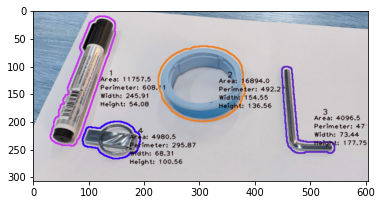

In [109]:
image = cv2.imread("objects.png", cv2.IMREAD_COLOR)
#@title Parameters { run: "auto" }
rank_by = 'perimeter' # @param ["area", "perimeter", "width", "height"]
res, sizes = calculate_sizes_and_rank(image, rank_by=rank_by)
plt.imshow(res)
plt.show()

## Problem 3. Calculate number of coins on the white paper

To do this prepocess image the following way:
1. convert image to gray scale
2. thredhold image so it becomes binary
3. apply dilation with 3x3 kernel
4. use `connectedComponentsWithStats` to differentiate coins

Then for each component, check that size is not too big (to remove table) draw it on the image and count. Return total number of coins on the white paper.

In [117]:
def coins_calculator(image):
  """
  Function calculates number of coins on the white paper
  Input:
    image: grayscale or color image
  Output:
    total_val: total value of coins
  """
  # conevert image to gray scale if needed
  if (len(image.shape) > 2):
    if image.shape[0] == 3: 
      image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
      image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  # threshold image
  ret, thresh = cv2.threshold(image_gray, 200, 255, cv2.THRESH_BINARY_INV)
  # dilation
  kernel = np.ones((3, 3), np.uint8)
  dilation = cv2.dilate(thresh, kernel, iterations=2)
  # Connected components
  res = cv2.connectedComponentsWithStats(dilation, 4, cv2.CV_32S)
  n, labels_im, stats, centroids = res[0], res[1], res[2], res[3]
  # Enumerate number of coins that do not touch table
  total_val = 0
  for i in range(n):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    width = stats[i, cv2.CC_STAT_WIDTH] # horizontal
    height = stats[i, cv2.CC_STAT_HEIGHT] # vertical
    area = stats[i, cv2.CC_STAT_AREA]
    # don't count table
    if area > 2000:
      continue
    # plus one more coin
    total_val += 1 
    # draw rectangle 
    color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
    cv2.rectangle(image, (x, y), (x + width, y + height), color, 2)
  # show image 
  plt.imshow(image)
  plt.show()
  return total_val

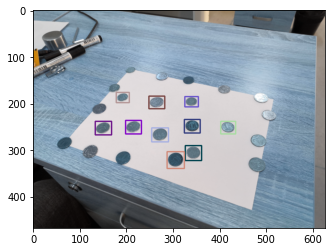

Total value: 10


In [118]:
image = cv2.imread("coins.png", cv2.IMREAD_COLOR)
total_value = coins_calculator(image)
print("Total value:", total_value)